# [Rework] Clustering Approach


In [1]:
from collections import Counter
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import talib
from tqdm.notebook import tqdm
from backtesting import Backtest, Strategy
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier

import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


def get_X(
        data: pd.DataFrame
):
    return data.filter(like='X').values


def get_y(
        data: pd.DataFrame,
        shift_window: int = 4,
        q_filter: float = .25
):
    y = data.close.pct_change(shift_window).shift(-shift_window)
    f_val = data.close.pct_change(shift_window).abs().quantile(q_filter)
    y[y.between(-f_val, f_val)] = 0
    y[y > 0] = 1
    y[y < 0] = -1
    return y, f_val


def feature_engineer(
    data: pd.DataFrame,
    shift_window: int = 4,
):
    close_ = data.close
    upperband, _, lowerband = talib.BBANDS(
        close_,
        timeperiod=20,
        nbdevup=2,
        nbdevdn=2,
        matype=0
    )

    sma05 = talib.SMA(close_, 5)
    sma10 = talib.SMA(close_, 10)
    sma20 = talib.SMA(close_, 20)
    sma50 = talib.SMA(close_, 50)
    sma100 = talib.SMA(close_, 100)

    data['X_SMA05'] = (close_ - sma05) / close_
    data['X_SMA10'] = (close_ - sma10) / close_
    data['X_SMA20'] = (close_ - sma20) / close_
    data['X_SMA50'] = (close_ - sma50) / close_
    data['X_SMA100'] = (close_ - sma100) / close_
    data['X_DELTA_SMA10'] = (sma10 - sma20) / close_
    data['X_DELTA_SMA20'] = (sma20 - sma50) / close_
    data['X_DELTA_SMA50'] = (sma50 - sma100) / close_

    data['X_BB_upper'] = (upperband - close_) / close_
    data['X_BB_lower'] = (lowerband - close_) / close_
    data['X_BB_width'] = (upperband - lowerband) / close_

    data['X_ROLLING_DIFF_Q05'] = data.close.diff(
        shift_window).rolling(20).quantile(.05)
    data['X_ROLLING_DIFF_Q25'] = data.close.diff(
        shift_window).rolling(20).quantile(.25)
    data['X_ROLLING_DIFF_Q50'] = data.close.diff(
        shift_window).rolling(20).quantile(.50)
    data['X_ROLLING_DIFF_Q75'] = data.close.diff(
        shift_window).rolling(20).quantile(.75)
    data['X_ROLLING_DIFF_Q95'] = data.close.diff(
        shift_window).rolling(20).quantile(.95)

    data['X_ROLLING_SKEW'] = data.close.rolling(20).skew()
    data['X_ROLLING_KURT'] = data.close.rolling(20).kurt()

    data['X_day'] = data.index.dayofweek
    data['X_hour'] = data.index.hour

    data = data.dropna().astype(float)
    return data


def get_clean_Xy(
        df: pd.DataFrame,
        q_filter: float = .75
):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y, f_val = get_y(df, q_filter=q_filter)
    y = y.values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y, f_val


def load(file_):
    try:
        _df = pd.read_csv(file_, parse_dates=True)
        _df.datetime = pd.to_datetime(_df.datetime)
        _df['date'] = _df.datetime.dt.date
        _df.set_index('datetime', inplace=True)
        return _df
    except Exception as e:
        return pd.DataFrame()


def load_historical_data(path_pattern, shift_window=4):

    file_df = pd.DataFrame(
        [
            {
                'stock_code': file_.split('/')[-2],
                'path': file_,
            } for file_ in glob(path_pattern)
        ]
    )
    if file_df.empty:
        return pd.DataFrame()

    df_map = {}

    for stock, group in tqdm(file_df.groupby('stock_code'), desc=path_pattern):
        df_map[stock] = pd.concat(
            list(
                map(
                    load,
                    sorted(group.path.tolist())
                )
            )
        ).sort_index()

    nifty_df = df_map[stock]

    if 'only_date' in nifty_df.columns:
        nifty_df.drop(columns=['only_date'], inplace=True)

    groups = []

    for _, group in nifty_df.groupby('date'):

        groups.append(
            feature_engineer(
                group[['open', 'high', 'low', 'close']],
                shift_window=shift_window
            )
        )

    return pd.concat(groups)


training_data = pd.concat(
    [
        load_historical_data(
            '/workspace/nifty/NIFTY/201*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/2020*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/2021*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/2022*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/20230*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/20231*.csv'
        )
    ]
)

test_data = pd.concat(
    [
        load_historical_data(
            # '/workspace/nifty/NIFTY/20231*.csv'
            # ), load_historical_data(
            '/workspace/nifty/NIFTY/2024*.csv'
        )
    ]
)


X, y, f_val = get_clean_Xy(training_data, q_filter=.40)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.4,
    random_state=0
)


train_X, train_y = [], []
max_counts = Counter(y_train).most_common()[0][1]
cls = 1

for cls in set(y_train):
    cls_index = (y_train == cls).nonzero()[0]
    resample_index = np.random.randint(0, len(cls_index), max_counts)
    train_X.append(X_train[resample_index]),
    train_y.append(y_train[resample_index])

train_X = np.concatenate(train_X)
train_y = np.concatenate(train_y)
train_X.shape, train_y.shape

/workspace/nifty/NIFTY/201*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/2020*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/2021*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/2022*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/20230*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/20231*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/2024*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

((435426, 20), (435426,))

In [2]:

class MLTrainOnceStrategy(Strategy):
    f_val = None  # 0.4%
    clf = None
    _pbar = None
    daily_loss_limit = 20

    def __init__(self, broker, data, params):
        super().__init__(broker, data, params)
        self.clf = params['clf']
        self.f_val = params['f_val']
        self._pbar = tqdm(
            total=len(data)-1,
            leave=False,
        )

    def _is_trading_window(self):
        if (
            self.data.index[-1].hour == 15 and
            self.data.index[-1].minute > 20
        ) or (
            self.data.index[-1].hour == 9 and
            self.data.index[-1].minute < 30
        ):
            return False
        return True

    def init(self):
        self.forecasts = self.I(lambda: np.repeat(
            np.nan, len(self.data)), name='forecast')

    def next(self):

        closed_pnl = [trade.pl for trade in self.closed_trades]
        if self._pbar is not None:
            try:
                mean_pnl = np.quantile(
                    np.array(
                        closed_pnl
                    ),
                    [.05, .25, .5, .75, .95]
                ).round(1)
            except Exception:
                mean_pnl = np.zeros(5)

            self._pbar.update(1)
            self._pbar.set_description(
                f'{self.clf.__class__.__name__} {mean_pnl}'
            )

        if not self._is_trading_window():
            self.position.close()
            return

        current_date = self.data.index[-1].date()

        todays_trades = np.sum(
            [
                trade.pl for trade in self.closed_trades
                if trade.entry_time.date() == current_date
            ]
        )
        if todays_trades < -self.daily_loss_limit:
            self.position.close()
            return

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]
        self.forecasts[-1] = forecast

        upper, lower = close[-1] * (1 + np.r_[2, -1]*self.f_val)

        if forecast == 1 and not self.position.is_long:
            self.position.close()
            self.buy(
                size=1,
                tp=upper,
                sl=lower
            )
        elif forecast == -1 and not self.position.is_short:
            self.position.close()
            self.sell(
                size=1,
                tp=lower,
                sl=upper
            )

        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 hours'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)

In [3]:
mdf = pd.DataFrame()
classifiers = {}
cluster_matches = list(range(5, 41, 5))

for k in tqdm(cluster_matches):
    classifiers[k] = KNeighborsClassifier(k)
    classifiers[k].fit(X_train, y_train)
    y_pred = classifiers[k].predict(X_test)
    print(classification_report(y_test, y_pred))
    bt = Backtest(
        test_data.rename(
            {
                'open': 'Open',
                'high': 'High',
                'low': 'Low',
                'close': 'Close',
            },
            axis=1
        ),
        MLTrainOnceStrategy,
        cash=30000,
    )
    stats = bt.run(clf=classifiers[k], f_val=f_val)
    stats['K'] = k
    mdf[classifiers[k].__class__.__name__+str(k)] = stats
    # print(classification_report(y_test, y_pred))

mdf.T

  0%|          | 0/8 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        -1.0       0.42      0.50      0.45     71398
         0.0       0.49      0.54      0.52     96381
         1.0       0.48      0.32      0.39     73744

    accuracy                           0.46    241523
   macro avg       0.46      0.45      0.45    241523
weighted avg       0.47      0.46      0.46    241523



  0%|          | 0/5351 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        -1.0       0.41      0.40      0.40     71398
         0.0       0.48      0.57      0.53     96381
         1.0       0.43      0.33      0.37     73744

    accuracy                           0.45    241523
   macro avg       0.44      0.44      0.43    241523
weighted avg       0.44      0.45      0.44    241523



  0%|          | 0/5351 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        -1.0       0.40      0.37      0.38     71398
         0.0       0.48      0.59      0.53     96381
         1.0       0.42      0.32      0.36     73744

    accuracy                           0.44    241523
   macro avg       0.43      0.43      0.43    241523
weighted avg       0.44      0.44      0.44    241523



  0%|          | 0/5351 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        -1.0       0.39      0.34      0.36     71398
         0.0       0.47      0.62      0.54     96381
         1.0       0.41      0.30      0.35     73744

    accuracy                           0.44    241523
   macro avg       0.43      0.42      0.42    241523
weighted avg       0.43      0.44      0.43    241523



  0%|          | 0/5351 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        -1.0       0.39      0.31      0.35     71398
         0.0       0.47      0.63      0.54     96381
         1.0       0.41      0.31      0.35     73744

    accuracy                           0.44    241523
   macro avg       0.42      0.42      0.41    241523
weighted avg       0.43      0.44      0.43    241523



  0%|          | 0/5351 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        -1.0       0.39      0.30      0.34     71398
         0.0       0.47      0.64      0.54     96381
         1.0       0.40      0.30      0.34     73744

    accuracy                           0.44    241523
   macro avg       0.42      0.41      0.41    241523
weighted avg       0.43      0.44      0.42    241523



  0%|          | 0/5351 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        -1.0       0.38      0.29      0.33     71398
         0.0       0.47      0.65      0.55     96381
         1.0       0.40      0.29      0.34     73744

    accuracy                           0.44    241523
   macro avg       0.42      0.41      0.41    241523
weighted avg       0.42      0.44      0.42    241523



  0%|          | 0/5351 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        -1.0       0.39      0.28      0.32     71398
         0.0       0.47      0.66      0.55     96381
         1.0       0.40      0.29      0.34     73744

    accuracy                           0.43    241523
   macro avg       0.42      0.41      0.40    241523
weighted avg       0.42      0.43      0.42    241523



  0%|          | 0/5351 [00:00<?, ?it/s]

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],Volatility (Ann.) [%],...,Avg. Trade [%],Max. Trade Duration,Avg. Trade Duration,Profit Factor,Expectancy [%],SQN,_strategy,_equity_curve,_trades,K
KNeighborsClassifier5,2024-01-01 10:53:00,2024-01-25 15:29:00,24 days 04:36:00,42.582212,30294.86096,30398.907411,0.98287,-1.68582,7.954089,2.928871,...,0.001427,0 days 00:31:00,0 days 00:02:00,1.111294,0.001431,1.448737,"MLTrainOnceStrategy(clf=,f_val=0.0002575537188...",Equity DrawdownPct ...,Size EntryBar ExitBar EntryPrice E...,5
KNeighborsClassifier10,2024-01-01 10:53:00,2024-01-25 15:29:00,24 days 04:36:00,49.084454,30281.010538,30466.133553,0.936702,-1.68582,7.919483,3.356402,...,0.00113,0 days 00:17:00,0 days 00:02:00,1.090343,0.001134,1.291994,"MLTrainOnceStrategy(clf=,f_val=0.0002575537188...",Equity DrawdownPct...,Size EntryBar ExitBar EntryPrice ...,10
KNeighborsClassifier15,2024-01-01 10:53:00,2024-01-25 15:29:00,24 days 04:36:00,40.54559,29977.505404,30166.70492,-0.074982,-1.68582,-2.690458,2.673598,...,-0.000126,0 days 00:44:00,0 days 00:02:00,0.990954,-0.000121,-0.113832,"MLTrainOnceStrategy(clf=,f_val=0.0002575537188...",Equity DrawdownPct...,Size EntryBar ExitBar EntryPrice E...,15
KNeighborsClassifier20,2024-01-01 10:53:00,2024-01-25 15:29:00,24 days 04:36:00,48.654709,30102.243059,30248.255829,0.34081,-1.68582,5.899708,2.960592,...,0.000418,0 days 00:44:00,0 days 00:02:00,1.031446,0.000423,0.454832,"MLTrainOnceStrategy(clf=,f_val=0.0002575537188...",Equity DrawdownPct...,Size EntryBar ExitBar EntryPrice ...,20
KNeighborsClassifier25,2024-01-01 10:53:00,2024-01-25 15:29:00,24 days 04:36:00,49.30867,30186.379601,30299.499088,0.621265,-1.68582,8.062842,3.044969,...,0.000745,0 days 00:44:00,0 days 00:02:00,1.05713,0.00075,0.836232,"MLTrainOnceStrategy(clf=,f_val=0.0002575537188...",Equity DrawdownPct...,Size EntryBar ExitBar EntryPrice ...,25
KNeighborsClassifier30,2024-01-01 10:53:00,2024-01-25 15:29:00,24 days 04:36:00,41.405082,30193.121257,30303.291779,0.643738,-1.68582,10.024038,3.162052,...,0.000927,0 days 00:35:00,0 days 00:02:00,1.071608,0.000931,0.943273,"MLTrainOnceStrategy(clf=,f_val=0.0002575537188...",Equity DrawdownPct...,Size EntryBar ExitBar EntryPrice E...,30
KNeighborsClassifier35,2024-01-01 10:53:00,2024-01-25 15:29:00,24 days 04:36:00,40.78849,30276.621179,30430.854815,0.922071,-1.68582,12.213567,3.691686,...,0.001522,0 days 00:32:00,0 days 00:02:00,1.11934,0.001526,1.43817,"MLTrainOnceStrategy(clf=,f_val=0.0002575537188...",Equity DrawdownPct...,Size EntryBar ExitBar EntryPrice E...,35
KNeighborsClassifier40,2024-01-01 10:53:00,2024-01-25 15:29:00,24 days 04:36:00,44.35725,30202.521719,30322.990622,0.675072,-1.68582,9.012317,3.113376,...,0.000933,0 days 00:35:00,0 days 00:02:00,1.068354,0.000938,0.940074,"MLTrainOnceStrategy(clf=,f_val=0.0002575537188...",Equity DrawdownPct...,Size EntryBar ExitBar EntryPrice E...,40


In [4]:
# mdf = pd.DataFrame()
# # classifiers = {}


# for k in tqdm(cluster_matches):
#     # classifiers[k] = KNeighborsClassifier(k)
#     # classifiers[k].fit(X_train, y_train)
#     # y_pred = classifiers[k].predict(X_test)
#     # print(classification_report(y_test, y_pred))
#     bt = Backtest(
#         test_data.rename(
#             {
#                 'open': 'Open',
#                 'high': 'High',
#                 'low': 'Low',
#                 'close': 'Close',
#             },
#             axis=1
#         ),
#         MLTrainOnceStrategy,
#         cash=30000,
#     )
#     stats = bt.run(clf=classifiers[k], f_val=f_val)
#     stats['K'] = k
#     mdf[classifiers[k].__class__.__name__+str(k)] = stats
#     # print(classification_report(y_test, y_pred))

# mdf.T

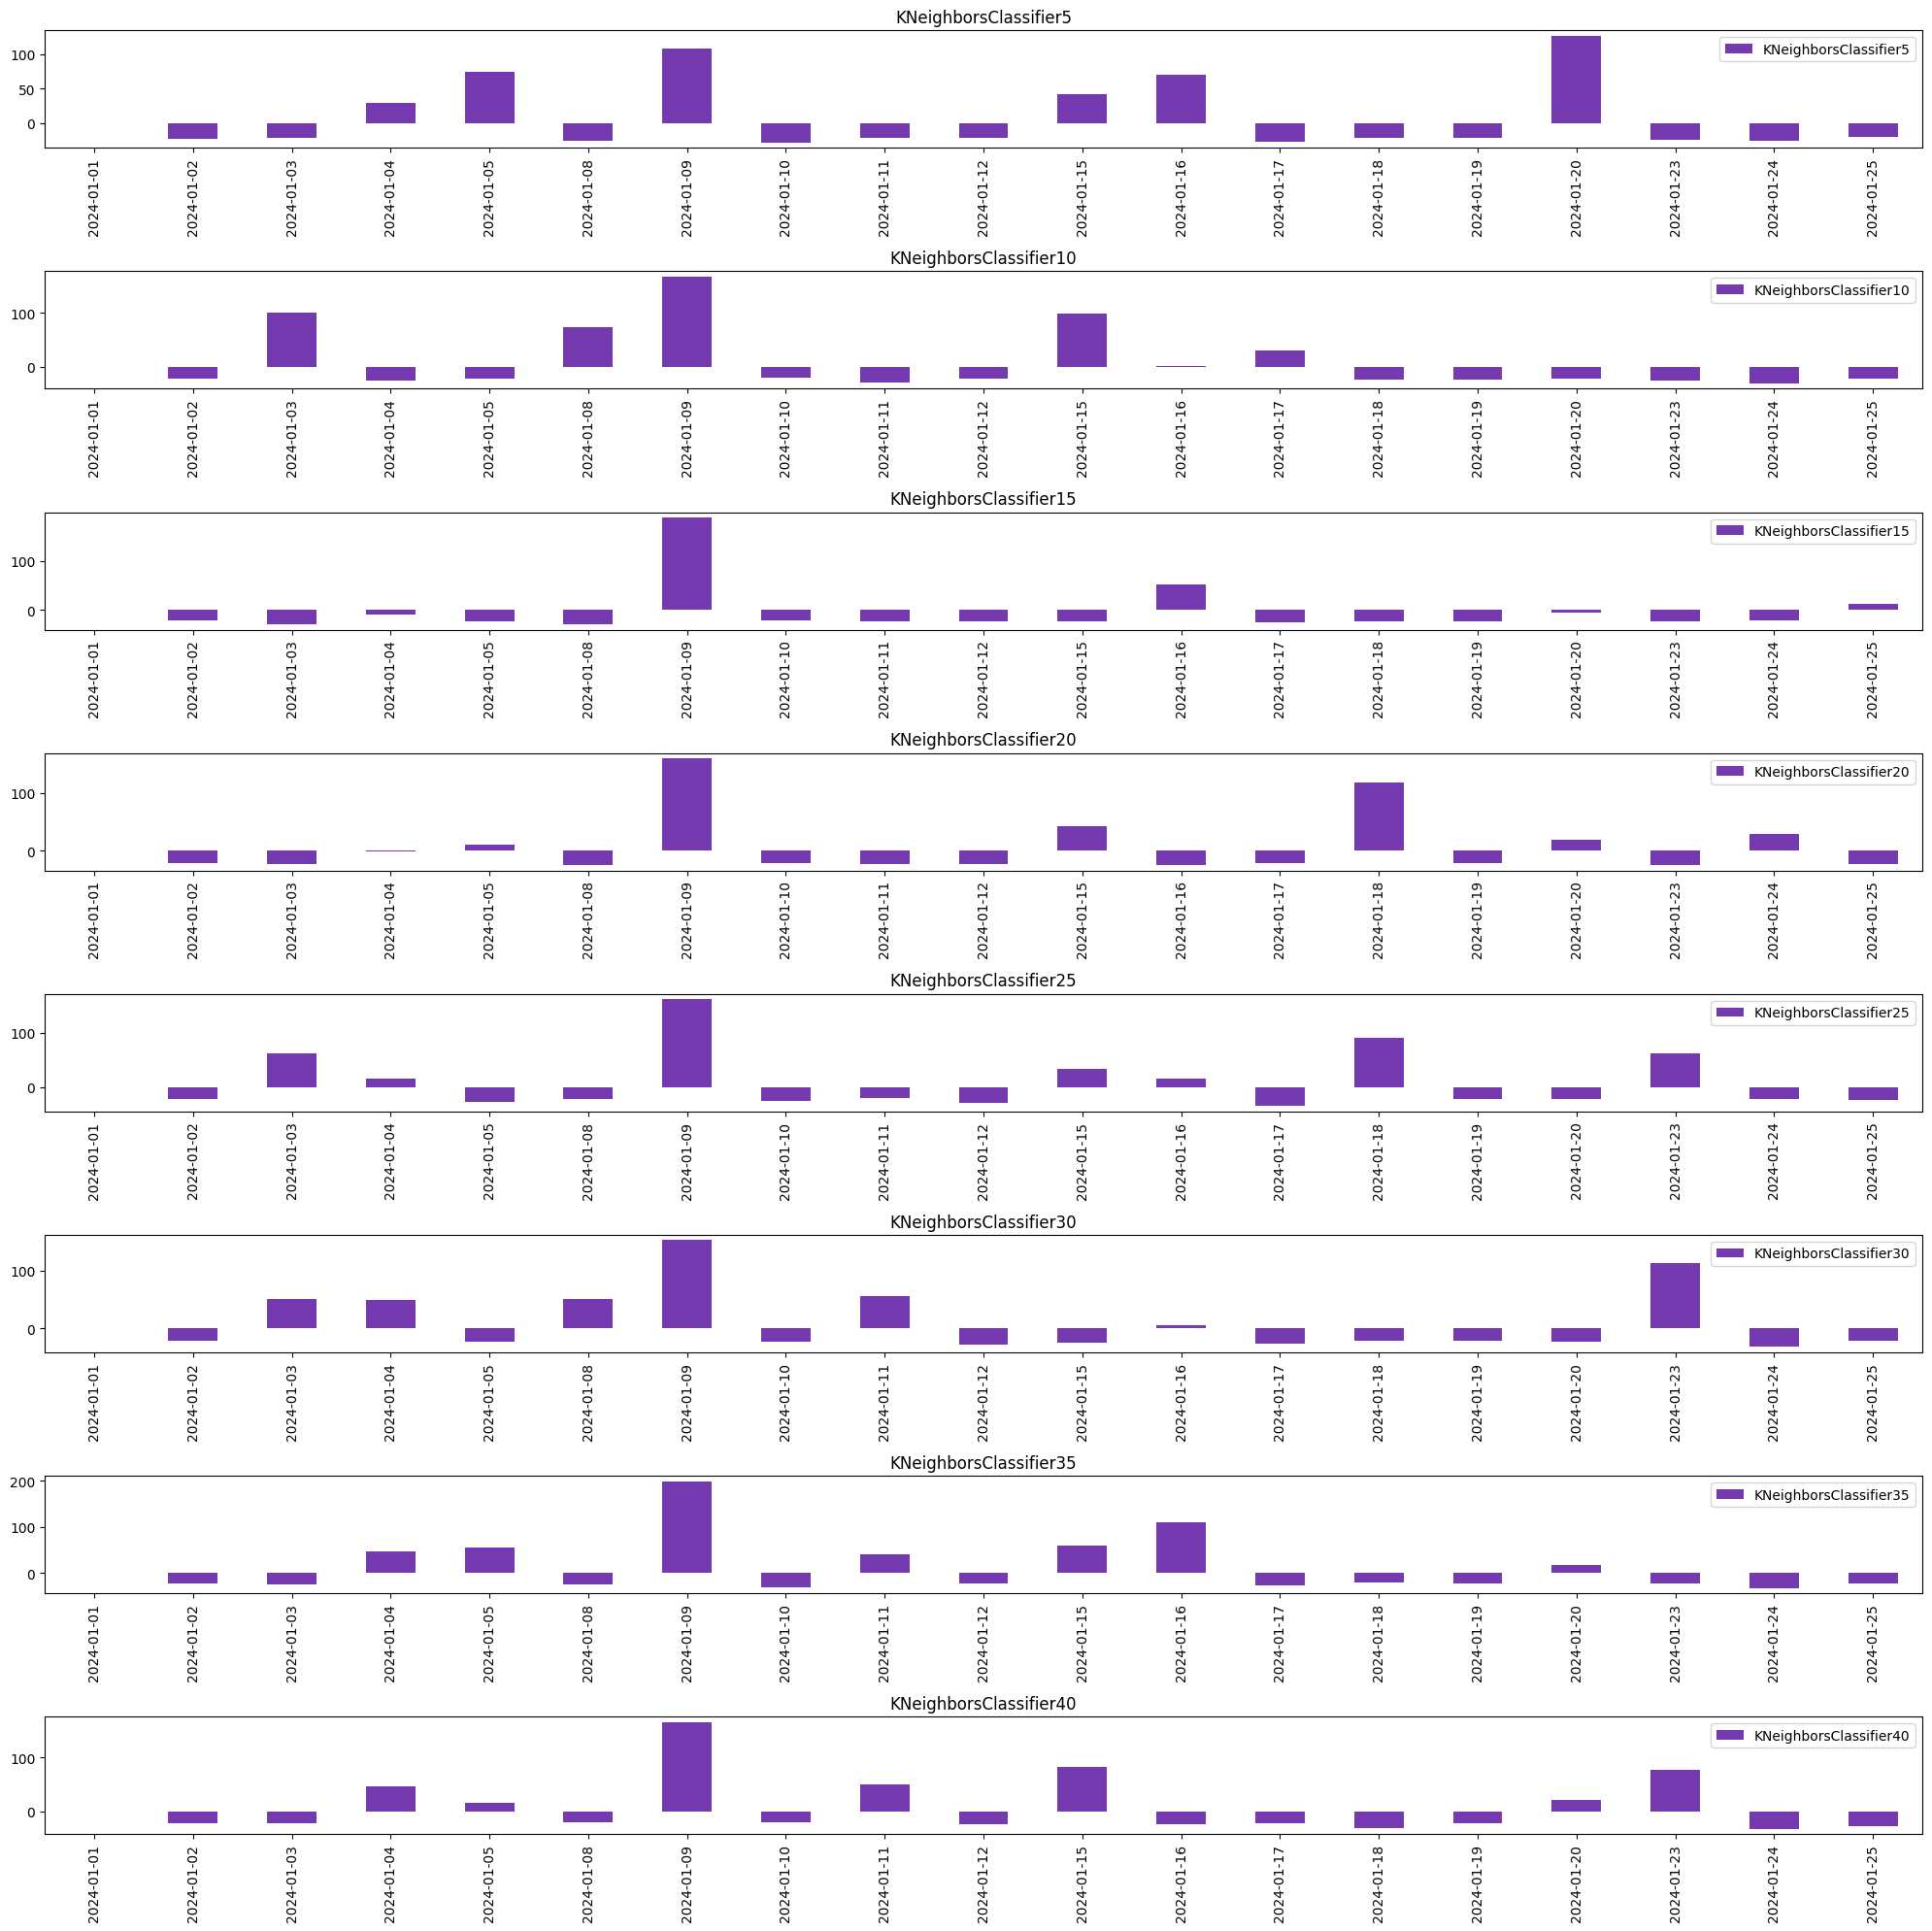

In [5]:
fig, ax = plt.subplots(figsize=(20, 20), sharex=True, sharey=True)


def random_hex_color():
    return '#'+(''.join(np.random.choice(list('0123456789ABCDEF'), size=6).tolist()))


# ax.axhline(0, color='k', lw=1)
# ax.axhline(-20, color='k', lw=1)
mdf.T.apply(
    lambda x: x._equity_curve.groupby(
        x._equity_curve.index.date).Equity.last().diff(),
    axis=1).T.plot.bar(subplots=True, ax=ax, color=random_hex_color())
# .plot.bar(ax=ax, color=random_hex_color())
# random_hex_color()
plt.tight_layout()
plt.show()

In [6]:
mdf.T[['Duration', '# Trades', 'Win Rate [%]']]
# ._trades[0]

,Duration,# Trades,Win Rate [%]
KNeighborsClassifier5,24 days 04:36:00,938,54.904051
KNeighborsClassifier10,24 days 04:36:00,1133,52.780229
KNeighborsClassifier15,24 days 04:36:00,907,50.496141
KNeighborsClassifier20,24 days 04:36:00,1123,50.222618
KNeighborsClassifier25,24 days 04:36:00,1144,51.311189
KNeighborsClassifier30,24 days 04:36:00,960,50.208333
KNeighborsClassifier35,24 days 04:36:00,823,51.032807
KNeighborsClassifier40,24 days 04:36:00,988,51.315789


In [7]:
mdf.T._trades.apply(lambda tdf: tdf.groupby(tdf.EntryTime.dt.date).PnL.sum(
).quantile([.05, .25, .5, .60, .75, .95]).round(2))
# .T.plot.bar(subplots=True, figsize=(20, 20))

,0.05,0.25,0.50,0.60,0.75,0.95
KNeighborsClassifier5,-26.54,-22.93,-20.71,-20.15,56.10,121.12
KNeighborsClassifier10,-29.98,-24.08,-22.63,-20.88,51.45,113.47
KNeighborsClassifier15,-28.68,-23.14,-22.03,-20.98,-6.61,65.97
KNeighborsClassifier20,-24.96,-23.16,-21.05,-20.79,15.12,122.30
KNeighborsClassifier25,-28.99,-22.43,-20.96,4.31,25.05,97.75
KNeighborsClassifier30,-28.71,-23.22,-21.52,-20.79,50.05,116.82
KNeighborsClassifier35,-31.23,-23.42,-21.85,7.64,44.45,120.22
KNeighborsClassifier40,-30.18,-22.76,-20.19,1.31,34.11,90.41


In [8]:
# from option_history import get_nifty
# import requests

# requests.get('http://localhost:4003/login')
# nifty_df = get_nifty()
# nifty_df.columns = [col.lower() for col in nifty_df.columns]
# ndf = feature_engineer(nifty_df[['open', 'high', 'low', 'close']])
# bt = Backtest(
#     ndf.rename(
#         {
#             'open': 'Open',
#             'high': 'High',
#             'low': 'Low',
#             'close': 'Close',
#         },
#         axis=1
#     ),
#     MLTrainOnceStrategy,
#     cash=30000,
# )
# t_stats = bt.run(clf=classifiers[1], f_val=f_val)

# t_stats._equity_curve.Equity.plot(figsize=(15, 5))
# print(
#     (t_stats['Equity Final [$]']-30000) * .8 * 50 * 5,
#     t_stats._trades.PnL.quantile([.05, .25, .5, .75, .95]),
#     sep='\n'
# )


# t_stats